In [5]:
pip install pyhrv

Note: you may need to restart the kernel to use updated packages.


In [1]:
from matplotlib.figure import Figure
import json
import neurokit2 as nk
import pyarrow.parquet as pq
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import math
import biosppy
import pyhrv
import pyhrv.tools as tools
import pyhrv.time_domain as td
import pyhrv.frequency_domain as fd
import pyhrv.nonlinear as nl
import os
import collections
import warnings
import numpy as np

In [2]:
def calc_features_helper(ecg_data):
    try:
        # calculate R peaks and NNI
        # NNI = normal to normal interval (between succesive R-peaks)
        rpeaks = biosppy.signals.ecg.christov_segmenter(ecg_data, sampling_rate = 500)[0]
        nni = tools.nn_intervals(rpeaks)

        # calculate time domain, freq domain, nonlinear features
        td_f = td.time_domain(nni).as_dict()
        nl_f = nl.nonlinear(nni).as_dict()

        # remove invalid vals
        feat = collections.OrderedDict(list(td_f.items()) + list(nl_f.items()))
        # keys that are known to produce inf or nan for our dataset
        for k in ["fft_bands", "lomb_bands", "ar_bands", "sdnn_index", "sdann", "sampen", "dfa_alpha1", "dfa_alpha1_beats", "dfa_alpha2", "dfa_alpha2_beats", "fft_plot","nni_histogram", "lomb_plot", "ar_plot", "poincare_plot", "dfa_plot", "tachogram_plot"]:
            feat.pop(k, 0)
        return feat
    except Exception as e:
        print(e)
        pass

In [3]:
def calc_features(ecg_path):
    plt.ioff()
    # ex ecg_path = "SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"
    # get 12-lead data from stored parquet
    ecg_raw = pq.read_table(ecg_path).to_pandas()

    # initialize pd df that'll contain features for all leads
    lead_features = {"I": calc_features_helper(pd.to_numeric(ecg_raw["I"], errors = "coerce")),
                    "II": calc_features_helper(pd.to_numeric(ecg_raw["II"], errors = "coerce")),
                    "III": calc_features_helper(pd.to_numeric(ecg_raw["III"], errors = "coerce")),
                    "aVR": calc_features_helper(pd.to_numeric(ecg_raw["aVR"], errors = "coerce")),
                    "aVL": calc_features_helper(pd.to_numeric(ecg_raw["aVL"], errors = "coerce")),
                    "aVF": calc_features_helper(pd.to_numeric(ecg_raw["aVF"], errors = "coerce")),
                    "V1": calc_features_helper(pd.to_numeric(ecg_raw["V1"], errors = "coerce")),
                    "V2": calc_features_helper(pd.to_numeric(ecg_raw["V2"], errors = "coerce")),
                    "V3": calc_features_helper(pd.to_numeric(ecg_raw["V3"], errors = "coerce")),
                    "V4": calc_features_helper(pd.to_numeric(ecg_raw["V4"], errors = "coerce")),
                    "V5": calc_features_helper(pd.to_numeric(ecg_raw["V5"], errors = "coerce")),
                    "V6": calc_features_helper(pd.to_numeric(ecg_raw["V6"], errors = "coerce"))}
    df = pd.DataFrame(lead_features)
    return df

In [4]:
# quick test of calc features
warnings.filterwarnings("ignore")
df = calc_features("SAFE/Databases/mimic-iv-ecg-parquet/12839207/23:21:00_30_08_2164_12839207.parquet")
print(df.shape)

(26, 12)


In [4]:
def flatten_matrix(df, id):
    reshaped = df.T.reset_index(drop=True)
    flattened = reshaped.values.flatten().tolist()
    flattened.insert(0, id)
    res = pd.DataFrame([flattened], index=[0], columns=cols_name)
    return res


In [13]:
# for HF positive patients
import csv

# import CSV w/ list of all HF positive patient IDs
pos_id = []
pos_csv = open("SAFE/hf_pt_id.csv", "r")
for row in pos_csv:
    pos_id.append(row[:-1])
pos_id = pos_id[1:]
print(len(set(pos_id)))

# 8598 total pos HF patients

8598


In [6]:
# ignoring the warnings that get generated from features that aren't being used in our model
warnings.filterwarnings("ignore")

# str_ex = "SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"



In [7]:
names = ['nni_counter', 'nni_mean', 'nni_min', 'nni_max', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'nni_diff_mean', 'nni_diff_min', 'nni_diff_max', 'sdnn', 'rmssd', 'sdsd', 'nn50', 'pnn50', 'nn20', 'pnn20', 'tinn_n', 'tinn_m', 'tinn', 'tri_index', 'sd1', 'sd2', 'sd_ratio', 'ellipse_area']
cols_name = ["subject_id"]
count = 1
while count != 13:
    for name in names:
        cols_name.append(name + "_lead" + str(count))
    count+=1
print(len(cols_name))

313


In [150]:
# (NOTE: Don't run this cell once extraction has started

# initialize feature table
#feature_table = pd.DataFrame([[0] * 313], columns=cols_name)
#print(feature_table)
#feature_table.to_csv("SAFE/advanced_ecg_features.csv", index=False)

   subject_id  nni_counter_lead1  nni_mean_lead1  nni_min_lead1  \
0           0                  0               0              0   

   nni_max_lead1  hr_mean_lead1  hr_min_lead1  hr_max_lead1  hr_std_lead1  \
0              0              0             0             0             0   

   nni_diff_mean_lead1  ...  nn20_lead12  pnn20_lead12  tinn_n_lead12  \
0                    0  ...            0             0              0   

   tinn_m_lead12  tinn_lead12  tri_index_lead12  sd1_lead12  sd2_lead12  \
0              0            0                 0           0           0   

   sd_ratio_lead12  ellipse_area_lead12  
0                0                    0  

[1 rows x 313 columns]


In [151]:
# DON'T RUN ABOVE CELL

In [15]:
df = pd.read_csv("SAFE/advanced_ecg_features.csv")
extracted_df = df.drop_duplicates(subset=["subject_id"])
extracted_df.drop(columns = "Unnamed: 0.1.1.1.1.1.1.1.1.1.1", inplace=True)
extracted_df.to_csv("SAFE/advanced_ecg_features.csv")
extracted = pd.read_csv("SAFE/advanced_ecg_features.csv")["subject_id"].tolist()

# check unique length
print(len(extracted))
print(len(set(extracted)))

8596
8596


In [19]:
# extract advanced ecg features for pos HF patients 
# extract in chunks (# = counter) to preserve kernel
counter = 0
batch = 0 # change this
for id in pos_id:
    if counter !=batch:
        if int(id) not in extracted:
            path = "SAFE/Databases/mimic-iv-ecg-parquet/" + id
            if os.path.exists(path):
                print(path)
                entries = os.scandir(path)
                files = [entry.path for entry in entries if entry.is_file()]

                # extract features (use the first recording)
                features_full = calc_features(min(files))
                features = flatten_matrix(features_full, min(files).split("/")[3])
                features2 = features.fillna(value=np.nan)     

                # concat here to the main table   
                curr_table = pd.read_csv("SAFE/advanced_ecg_features.csv")
                new_table = pd.concat([curr_table, features2])
                new_table.to_csv("SAFE/advanced_ecg_features.csv", index=False)
                print(curr_table.shape)

                # for progress purposes
                counter+=1
            print(counter)

0
0
0


In [26]:
# duplicate clean up and save
df = pd.read_csv("SAFE/advanced_ecg_features.csv")
df2 = df.drop(columns = ["Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1", "Unnamed: 0.1.1.1.1", "Unnamed: 0.1.1.1", "Unnamed: 0.1.1", "Unnamed: 0.1", "Unnamed: 0"], inplace=False)
df2.to_csv("SAFE/adv_ecg_features_hf_pos.csv")


[ 0.075  0.065  0.055 ... -0.02  -0.025 -0.025]


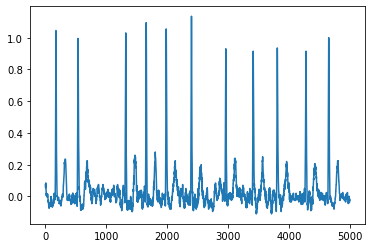

In [46]:
# sanityabove ecg lead visualized
ecg_path = "SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"
record = wfdb.rdrecord("SAFE/Databases/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1040/p10400173/s43577400/43577400")
lead = record.p_signal[:, record.sig_name.index("I")]
print(lead)
plt.plot(lead)
plt.show()